COVARIATE DISTRIBUTION SUMMARY

📊 AGE
------------------------------------------------------------
Unique values:
[75 50 12 70 30 60 85 80  8]
Total unique: 9
Missing values: 0 / 156

📊 ETHNICITY
------------------------------------------------------------
Unique values:
['European' 'African' 'Asian']
Total unique: 3
Missing values: 0 / 156

📊 GENDER
------------------------------------------------------------
Unique values:
['female' 'male']
Total unique: 2
Missing values: 0 / 156

📊 EDUCATION
------------------------------------------------------------
Unique values:
['high school diploma or lower' 'medical degree' 'university degree']
Total unique: 3
Missing values: 0 / 156

📊 DIAGNOSIS
------------------------------------------------------------
Unique values:
['pancreatic cancer' 'Chronic Ischemic Heart Disease' 'obesity'
 'Alzheimer’s']
Total unique: 4
Missing values: 0 / 156

📊 TREATMENT_OUTLOOK
------------------------------------------------------------
Unique values:
['a limi

/var/folders/c0/44p3b4xx4v956042lj_vp7z80000gn/T/ipykernel_37875/3253876437.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


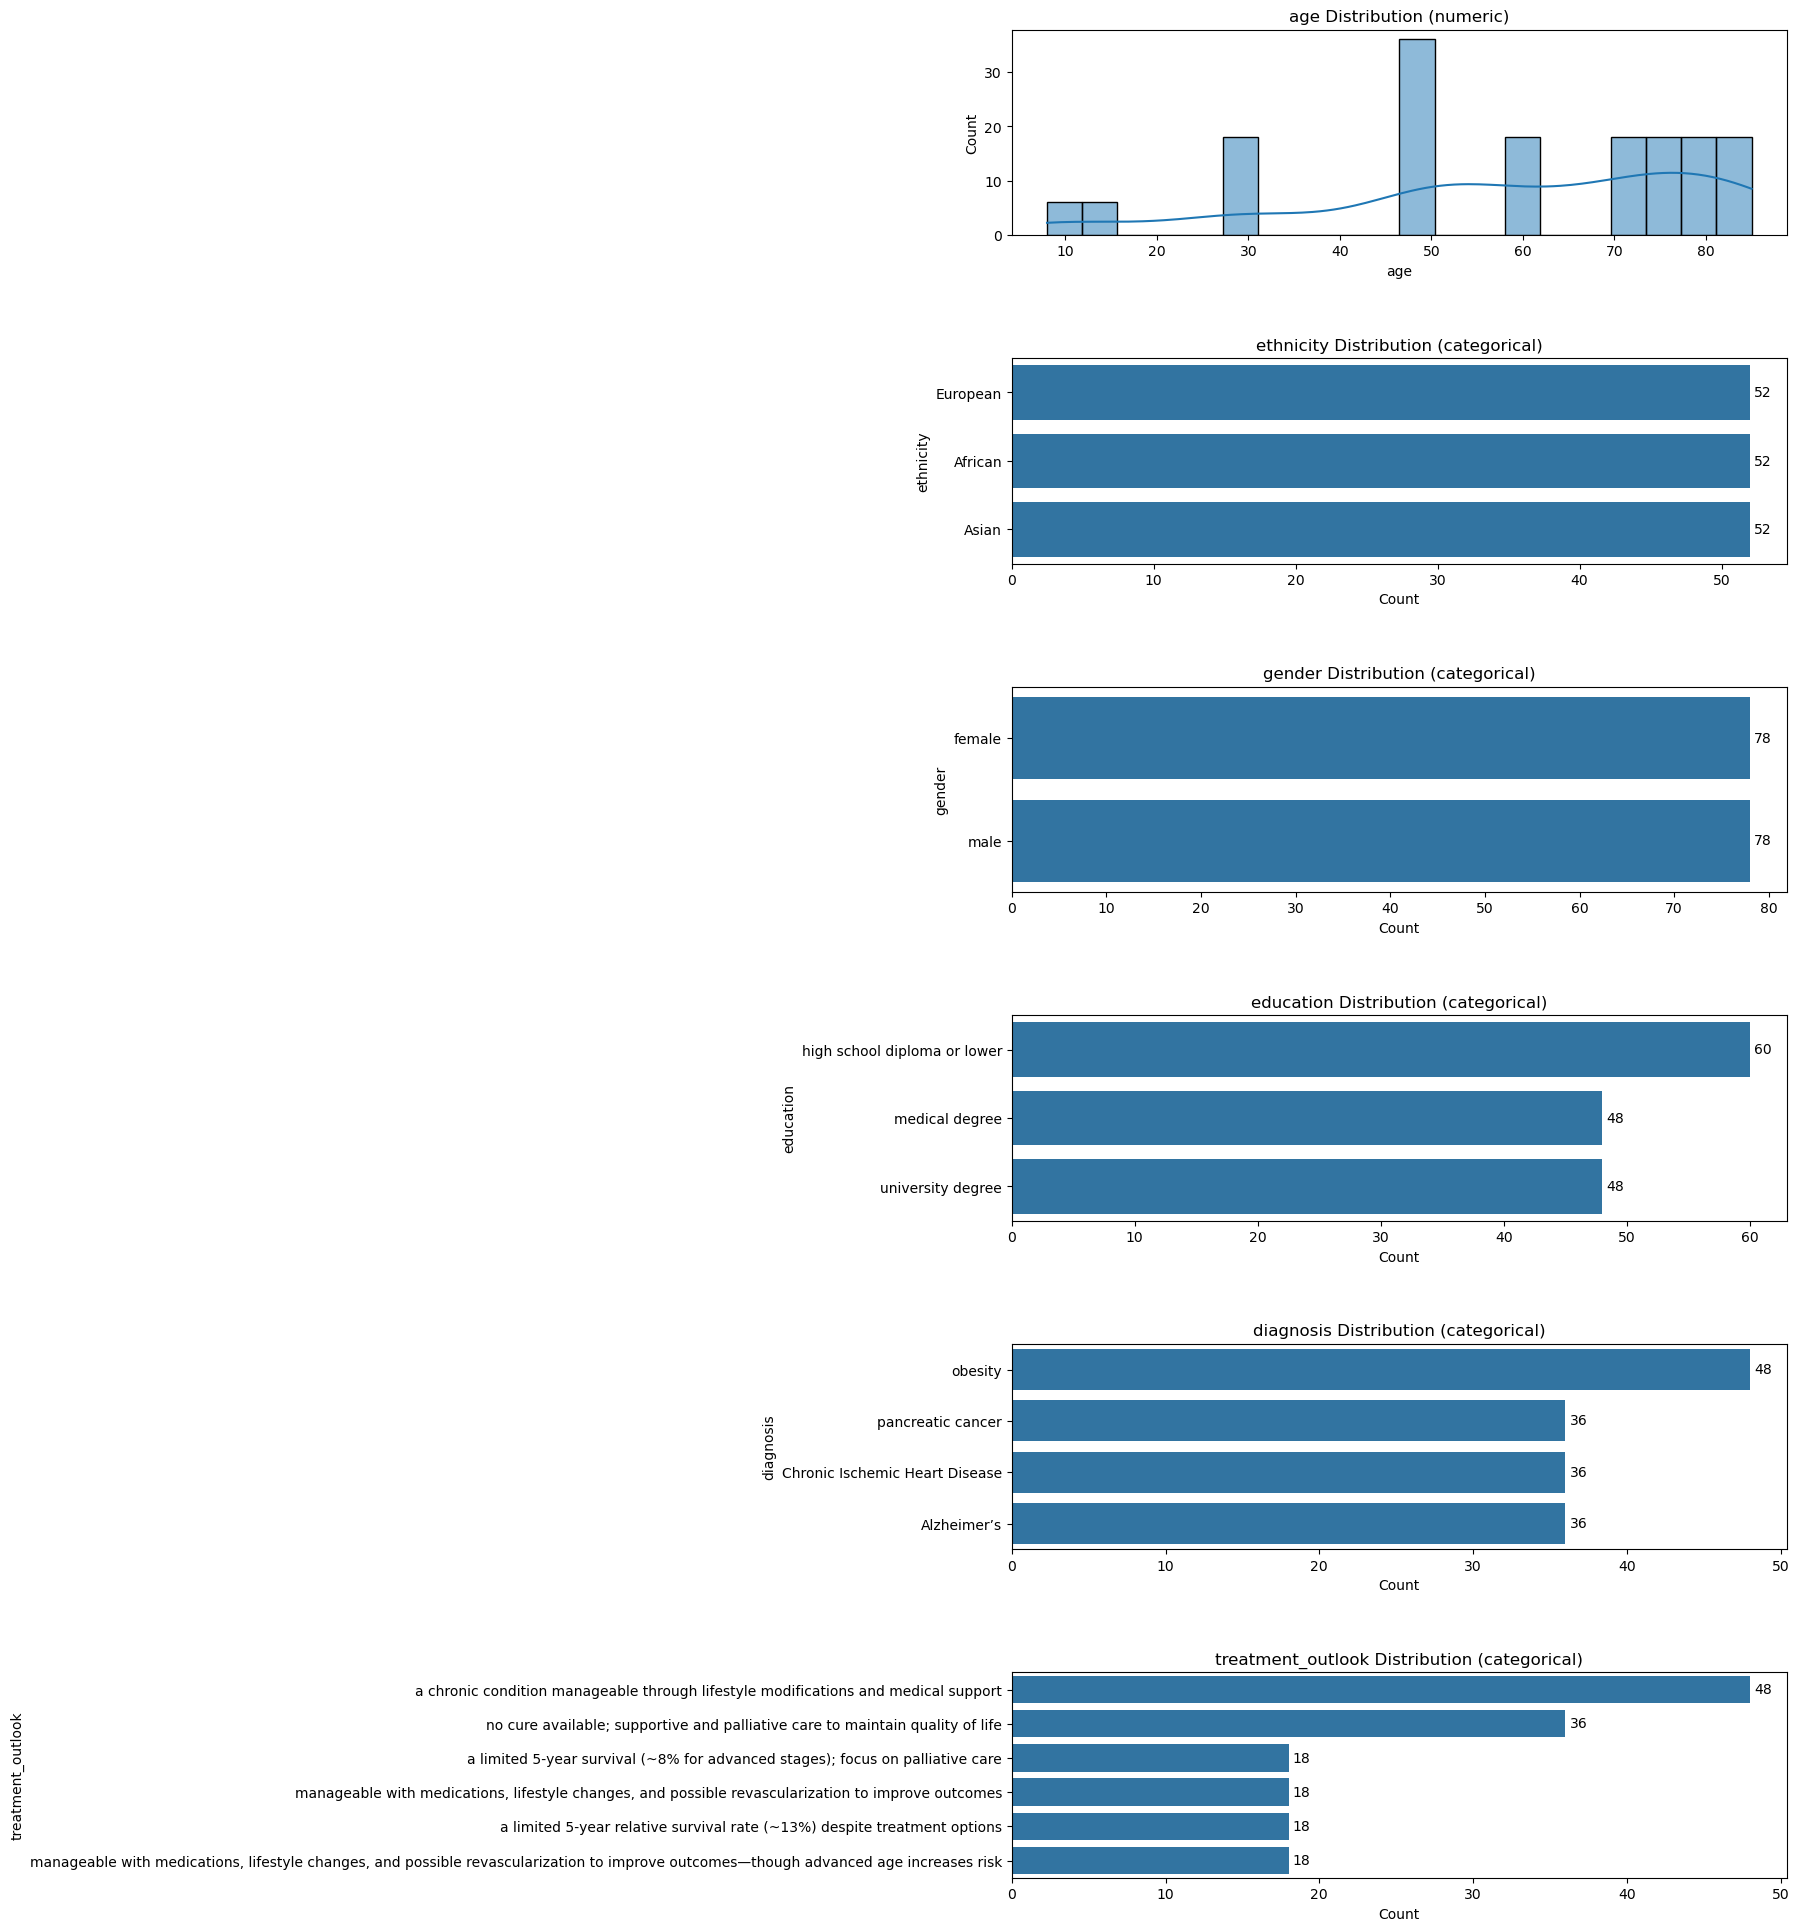

In [1]:
# 🧭 Covariate Distribution Overview
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data (update path if needed)
df = pd.read_csv("/Users/jianzhouyao/AI4Good/data/processed/ratings/claude_with_ratings.csv")

# Define covariates of interest
covariates = ["age", "ethnicity", "gender", "education", "diagnosis", "treatment_outlook"]

# Create summary table
print("="*80)
print("COVARIATE DISTRIBUTION SUMMARY")
print("="*80)
for col in covariates:
    print(f"\n📊 {col.upper()}")
    print("-"*60)
    print("Unique values:")
    print(df[col].dropna().unique())
    print(f"Total unique: {df[col].nunique()}")
    print(f"Missing values: {df[col].isna().sum()} / {len(df)}")

# Plot distributions
n = len(covariates)
fig, axes = plt.subplots(n, 1, figsize=(10, 4*n))
plt.subplots_adjust(hspace=0.6)

for i, col in enumerate(covariates):
    ax = axes[i]
    if df[col].dtype.kind in "biufc":  # numeric → histogram
        sns.histplot(df[col].dropna(), bins=20, kde=True, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.set_title(f"{col} Distribution (numeric)")
    else:  # categorical → barplot
        counts = df[col].value_counts(dropna=False)
        sns.barplot(x=counts.values, y=counts.index, ax=ax)
        ax.set_xlabel("Count")
        ax.set_ylabel(col)
        ax.set_title(f"{col} Distribution (categorical)")
        for c in ax.containers:
            ax.bar_label(c, fmt="%d", label_type="edge", padding=3)
plt.tight_layout()
plt.show()


In [14]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Global plotting style
# ==============================
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.3)

plt.rcParams.update({
    "font.size": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 20,
    "figure.constrained_layout.use": True,
})

custom_palette = sns.color_palette("viridis", 4)
sns.set_palette(custom_palette)

FIGSIZE = (14, 7)
DPI = 300
XTICK_ROT = 30

# ==============================
# Paths & data loading
# ==============================
current_dir = pathlib.Path().resolve()
project_root = current_dir.parent.parent

demographics_path = project_root / "Prompts_And_Response" / "data/raw/prompts/initial_prompts.csv"
prompts_df = pd.read_csv(
    demographics_path,
    usecols=["Prompt Number", "age", "ethnicity", "gender", "education", "diagnosis", "treatment_outlook"]
)
prompts_df["Prompt Number"] = prompts_df["Prompt Number"].astype(int)

# Rename ethnicity -> race for internal consistency
prompts_df = prompts_df.rename(columns={"ethnicity": "race"})

ratings_folder = project_root / "Ratings" / "Empathy"
file_paths = {
    "Claude Response + Claude Rating": ratings_folder / "claude_response_claude_rating.csv",
    "Claude Response + GPT Rating":    ratings_folder / "claude_response_gpt_rating.csv",
    "GPT Response + Claude Rating":    ratings_folder / "gpt_response_claude_rating.csv",
    "GPT Response + GPT Rating":       ratings_folder / "gpt_response_gpt_rating.csv",
}

frames = []
for label, path in file_paths.items():
    df = pd.read_csv(path)
    # Drop stale demo cols, then merge clean ones
    df = df.drop(columns=["age","ethnicity","race","gender","education","diagnosis","treatment_outlook"], errors="ignore")
    df = df.merge(prompts_df, on="Prompt Number", how="left")
    df["Source"] = label
    frames.append(df)

combined_df = pd.concat(frames, ignore_index=True)

# ==============================
# Clean/convert + canonicalize column names
# ==============================
combined_df["age"] = pd.to_numeric(combined_df["age"], errors="coerce")
combined_df.columns = combined_df.columns.str.strip()

# Map any known variants to canonical names
colmap_candidates = {
    # affective
    "Affective Empathy Score": "Affective Empathy",
    "Affective Empathy": "Affective Empathy",
    # cognitive
    "Cognitive Understanding Score": "Cognitive Empathy",
    "Cognitive Empathy Score": "Cognitive Empathy",
    "Cognitive Empathy": "Cognitive Empathy",
}
rename_actual = {c: colmap_candidates[c] for c in combined_df.columns if c in colmap_candidates}
combined_df = combined_df.rename(columns=rename_actual)

# Sanity check
required_cols = {"Affective Empathy", "Cognitive Empathy"}
missing = required_cols - set(combined_df.columns)
if missing:
    raise ValueError(
        f"Missing required score columns after renaming: {missing}\n"
        f"Available columns: {list(combined_df.columns)}"
    )

# ==============================
# Abbreviations
# ==============================
source_short_map = {
    "Claude Response + Claude Rating": "C→C",
    "Claude Response + GPT Rating":    "C→G",
    "GPT Response + Claude Rating":    "G→C",
    "GPT Response + GPT Rating":       "G→G",
}
combined_df["SourceShort"] = combined_df["Source"].map(source_short_map).fillna(combined_df["Source"])
source_short_order = ["C→C", "C→G", "G→C", "G→G"]

edu_labels_abbrev = {
    "high school diploma or lower": "HS",
    "university degree": "Univ",
    "medical degree": "Med",
}
diag_labels_abbrev = {
    "pancreatic cancer": "PanCan",
    "Chronic Ischemic Heart Disease": "CIHD",
    "obesity": "Obes",
    "Alzheimer’s": "Alz",
}
combined_df["education_abbrev"] = combined_df["education"].map(edu_labels_abbrev).fillna(combined_df["education"])
combined_df["diagnosis_abbrev"] = combined_df["diagnosis"].map(diag_labels_abbrev).fillna(combined_df["diagnosis"])

# ==============================
# Output folder
# ==============================
output_folder = project_root / "Scoring_Charts"
os.makedirs(output_folder, exist_ok=True)

# ==============================
# Helper function
# ==============================
def two_panel_with_bottom_legend(
    data, x1, x2, order1=None, order2=None, xlabel="",
    y1="Affective Empathy", y2="Cognitive Empathy",
    hue="SourceShort", hue_order=None, filename="figure.png"
):
    fig = plt.figure(figsize=FIGSIZE)

    ax1 = plt.subplot(1, 2, 1)
    sns.barplot(x=x1, y=y1, hue=hue, hue_order=hue_order, data=data,
                errorbar=("ci", 95), order=order1, ax=ax1)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(y1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=XTICK_ROT, ha="right")

    ax2 = plt.subplot(1, 2, 2)
    sns.barplot(x=x2, y=y2, hue=hue, hue_order=hue_order, data=data,
                errorbar=("ci", 95), order=order2, ax=ax2)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(y2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=XTICK_ROT, ha="right")

    if ax1.get_legend() is not None: ax1.get_legend().remove()
    if ax2.get_legend() is not None: ax2.get_legend().remove()

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False)

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    path = output_folder / filename
    plt.savefig(path, dpi=DPI, bbox_inches="tight")
    plt.close()
    return path


# ==============================
# (1) By Age Group
# ==============================
bins   = [0, 18, 50, 65, 100]
labels = ['<18', '18-49', '50-64', '65+']
combined_df['age_group'] = pd.cut(combined_df['age'], bins=bins, labels=labels, right=False)

age_path = two_panel_with_bottom_legend(
    combined_df, "age_group", "age_group",
    order1=labels, order2=labels, xlabel="Age Group",
    hue_order=source_short_order, filename="outputs/figures/demographics/scores_by_age.png"
)

# ==============================
# (2) By Education
# ==============================
edu_path = two_panel_with_bottom_legend(
    combined_df, "education_abbrev", "education_abbrev",
    order1=["HS","Univ","Med"], order2=["HS","Univ","Med"], xlabel="Education",
    hue_order=source_short_order, filename="outputs/figures/demographics/scores_by_education.png"
)

# ==============================
# (3) By Race
# ==============================
race_path = two_panel_with_bottom_legend(
    combined_df, "race", "race",
    xlabel="Race", hue_order=source_short_order,
    filename="outputs/figures/demographics/scores_by_race.png"
)

# ==============================
# (4) By Diagnosis
# ==============================
dx_path = two_panel_with_bottom_legend(
    combined_df, "diagnosis_abbrev", "diagnosis_abbrev",
    order1=["PanCan","CIHD","Obes","Alz"], order2=["PanCan","CIHD","Obes","Alz"],
    xlabel="Diagnosis", hue_order=source_short_order, filename="outputs/figures/demographics/scores_by_diagnosis.png"
)

print("✅ Saved A–D figures:")
for p in [age_path, edu_path, race_path, dx_path]:
    print(" -", p)

# ==============================
# (5) Gender Bias Visualization
# ==============================
_df = combined_df.copy()
_df["gender_norm"] = _df["gender"].astype(str).str.strip().str.lower()
_df["SourceShort"] = _df["Source"].map(source_short_map).fillna(_df["Source"])

bias_wide = (
    _df.groupby(["SourceShort", "gender_norm"])[["Affective Empathy", "Cognitive Empathy"]]
    .mean().unstack(level=-1)
)

aff_f = bias_wide[("Affective Empathy", "female")]
aff_m = bias_wide[("Affective Empathy", "male")]
cog_f = bias_wide[("Cognitive Empathy", "female")]
cog_m = bias_wide[("Cognitive Empathy", "male")]

bias = pd.DataFrame({
    "Affective": aff_f - aff_m,
    "Cognitive": cog_f - cog_m,
}).reindex([lab for lab in source_short_order if lab in bias_wide.index])

print("Gender Bias (Female - Male):")
print(bias.round(3))

plt.figure(figsize=FIGSIZE)
ax = plt.gca()
bar_containers = bias.plot(
    kind="bar", ax=ax, color=[custom_palette[0], custom_palette[1]],
    rot=0, width=0.8, legend=False
).containers

ax.axhline(0, color="black", linewidth=1.2, linestyle="--", alpha=0.7)
ax.set_xticklabels(bias.index, rotation=XTICK_ROT, ha="right")
ax.set_ylabel("Female − Male (mean difference)")
ax.set_xlabel("")

for container in bar_containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

handles = list(bar_containers)
labels  = bias.columns.tolist()
ax.legend(handles=handles, labels=labels,
          loc="upper center", bbox_to_anchor=(0.5, 1.20),
          ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.88])

gb_png = output_folder / "outputs/figures/bias/gender_bias_difference.png"
gb_pdf = output_folder / "outputs/figures/bias/gender_bias_difference.pdf"
plt.savefig(gb_png, dpi=DPI, bbox_inches="tight")
plt.savefig(gb_pdf, bbox_inches="tight")
plt.close()

print("✅ Saved:", gb_png)


✅ Saved A–D figures:
 - /Users/jianzhouyao/AI4Good/Scoring_Charts/scores_by_age.png
 - /Users/jianzhouyao/AI4Good/Scoring_Charts/scores_by_education.png
 - /Users/jianzhouyao/AI4Good/Scoring_Charts/scores_by_race.png
 - /Users/jianzhouyao/AI4Good/Scoring_Charts/scores_by_diagnosis.png
Gender Bias (Female - Male):
             Affective  Cognitive
SourceShort                      
C→C              0.090      0.013
C→G              0.051      0.103
G→C              0.013     -0.026
G→G              0.000      0.064
✅ Saved: /Users/jianzhouyao/AI4Good/Scoring_Charts/gender_bias_difference.png


In [8]:
# ==============================
# Gender Bias Visualization (Female vs. Male) — Original Style + 95% t-based CI
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Copy your unified style settings ---
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.3)
plt.rcParams.update({
    "font.size": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 20,
    "figure.constrained_layout.use": True,
})
custom_palette = sns.color_palette("viridis", 4)
sns.set_palette(custom_palette)

FIGSIZE = (14, 7)
DPI = 300
XTICK_ROT = 30

# ==============================
# Data preparation
# ==============================
_df = combined_df.copy()
_df["gender_norm"] = _df["gender"].astype(str).str.strip().str.lower()
_df["SourceShort"] = _df["Source"].map(source_short_map).fillna(_df["Source"])

source_short_order = ["C→C", "C→G", "G→C", "G→G"]

# ==============================
# Compute mean ± 95% CI for each Source and Metric
# ==============================
# Seaborn can compute t-based CI automatically through barplot
# We'll plot two panels (Affective / Cognitive) to match your aesthetic
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharey=True)

# ---- Affective Empathy
sns.barplot(
    data=_df,
    x="SourceShort", y="Affective Empathy",
    hue="gender_norm", hue_order=["female", "male"],
    order=source_short_order,
    errorbar=("ci", 95),   # 95% t-based CI
    ax=axes[0]
)
axes[0].axhline(0, color="black", linewidth=1.2, linestyle="--", alpha=0.7)
axes[0].set_xlabel("")
axes[0].set_ylabel("Affective Empathy (mean ±95% CI)")
axes[0].set_xticklabels(source_short_order, rotation=XTICK_ROT, ha="right")
axes[0].set_title("Affective Empathy", pad=15)

# ---- Cognitive Empathy
sns.barplot(
    data=_df,
    x="SourceShort", y="Cognitive Empathy",
    hue="gender_norm", hue_order=["female", "male"],
    order=source_short_order,
    errorbar=("ci", 95),
    ax=axes[1]
)
axes[1].axhline(0, color="black", linewidth=1.2, linestyle="--", alpha=0.7)
axes[1].set_xlabel("")
axes[1].set_ylabel("Cognitive Empathy (mean ±95% CI)")
axes[1].set_xticklabels(source_short_order, rotation=XTICK_ROT, ha="right")
axes[1].set_title("Cognitive Empathy", pad=15)

# ---- Unified legend (bottom, no frame)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, ["Female", "Male"],
    loc="lower center", ncol=2, frameon=False
)
axes[0].get_legend().remove()
axes[1].get_legend().remove()

plt.tight_layout(rect=[0, 0.12, 1, 1])

# ---- Save outputs
out_png = output_folder / "outputs/figures/bias/gender_bias_with_CIs.png"
out_pdf = output_folder / "gender_bias_mean_CI_original_style.pdf"
plt.savefig(out_png, dpi=DPI, bbox_inches="tight")
plt.savefig(out_pdf, bbox_inches="tight")
plt.close()

print("✅ Saved:", out_png)


✅ Saved: /Users/jianzhouyao/AI4Good/Scoring_Charts/gender_bias_mean_CI_original_style.png


In [13]:
from scipy.stats import ttest_ind

# Perform t-tests for Female vs Male per Source and Score Type
results = []
score_types = {
    "Affective Bias": "Affective Empathy Score",
    "Cognitive Bias": "Cognitive Understanding Score"
}

for source in combined_df["Source"].unique():
    df_sub = combined_df[combined_df["Source"] == source]
    for bias_label, score_col in score_types.items():
        female_scores = df_sub[df_sub["gender"] == "female"][score_col]
        male_scores   = df_sub[df_sub["gender"] == "male"][score_col]
        
        t_stat, p_value = ttest_ind(
            female_scores, male_scores, equal_var=False, nan_policy="omit"
        )
        female_mean = female_scores.mean()
        male_mean   = male_scores.mean()
        
        results.append({
            "Source": source,
            "Score Type": bias_label,
            "Female Mean": round(female_mean, 3),
            "Male Mean": round(male_mean, 3),
            "Bias (F - M)": round(female_mean - male_mean, 3),
            "t-statistic": round(t_stat, 3),
            "p-value": round(p_value, 4),
            "Significant (p<0.05)": "Yes" if p_value < 0.05 else "No"
        })

# Create DataFrame and export
bias_test_df = pd.DataFrame(results)
bias_test_df.to_csv(output_folder / "gender_bias_significance_tests.csv", index=False)

# Print to console
print("\n📊 Gender Bias T-Test Results:")
print(bias_test_df)



📊 Gender Bias T-Test Results:
                            Source      Score Type  Female Mean  Male Mean  \
0  Claude Response + Claude Rating  Affective Bias        2.128      2.038   
1  Claude Response + Claude Rating  Cognitive Bias        2.872      2.859   
2     Claude Response + GPT Rating  Affective Bias        2.372      2.321   
3     Claude Response + GPT Rating  Cognitive Bias        2.885      2.782   
4     GPT Response + Claude Rating  Affective Bias        2.346      2.333   
5     GPT Response + Claude Rating  Cognitive Bias        2.744      2.769   
6        GPT Response + GPT Rating  Affective Bias        2.679      2.679   
7        GPT Response + GPT Rating  Cognitive Bias        2.897      2.833   

   Bias (F - M)  t-statistic  p-value Significant (p<0.05)  
0         0.090        1.030   0.3047                   No  
1         0.013        0.221   0.8252                   No  
2         0.051        0.635   0.5265                   No  
3         0.103       

In [19]:
# PROPER EMPATHY ANALYSIS - Clean Data Structure
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, ttest_ind, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("EMPATHY ANALYSIS - PROPER DATA STRUCTURE")
print("=" * 80)

# Load the two files
claude_df = pd.read_csv('/Users/jianzhouyao/AI4Good/data/processed/ratings/claude_with_ratings.csv')
gpt_df = pd.read_csv('/Users/jianzhouyao/AI4Good/data/processed/ratings/gpt_with_ratings.csv')

print("📊 DATA OVERVIEW")
print("-" * 40)
print(f"Claude responses: {len(claude_df)} rows")
print(f"GPT responses: {len(gpt_df)} rows")
print(f"Total unique responses: {len(claude_df) + len(gpt_df)}")

# Add response source identifier
claude_df['Response_Source'] = 'Claude'
gpt_df['Response_Source'] = 'GPT'

# Create age groups in individual dataframes first
claude_df['age_group'] = pd.cut(claude_df['age'], 
                               bins=[0, 18, 50, 65, 100], 
                               labels=['<18', '18-49', '50-64', '65+'], 
                               right=False)

gpt_df['age_group'] = pd.cut(gpt_df['age'], 
                            bins=[0, 18, 50, 65, 100], 
                            labels=['<18', '18-49', '50-64', '65+'], 
                            right=False)

# Combine for demographic analysis
combined_df = pd.concat([claude_df, gpt_df], ignore_index=True)

print(f"\nPrompt overlap check:")
claude_prompts = set(claude_df['Prompt Number'])
gpt_prompts = set(gpt_df['Prompt Number'])
overlap = len(claude_prompts.intersection(gpt_prompts))
print(f"Shared prompt numbers: {overlap} (same demographic scenarios)")

print(f"\n📋 SCORE OVERVIEW")
print("-" * 40)
score_columns = [
    'Affective Empathy Score (GPT)', 
    'Affective Empathy Score (Claude)',
    'Cognitive Empathy Score (GPT)', 
    'Cognitive Empathy Score (Claude)'
]

for col in score_columns:
    scores = combined_df[col].dropna()
    print(f"{col}: {scores.min()}-{scores.max()}, mean={scores.mean():.2f}, n={len(scores)}")

print("\n" + "=" * 80)
print("1. RATER AGREEMENT ANALYSIS")
print("=" * 80)

def analyze_rater_agreement(df, response_type):
    """Analyze agreement between Claude and GPT raters"""
    print(f"\n🤝 RATER AGREEMENT: {response_type} Responses")
    print("-" * 50)
    
    # Affective empathy agreement
    aff_gpt = df['Affective Empathy Score (GPT)'].dropna()
    aff_claude = df['Affective Empathy Score (Claude)'].dropna()
    
    if len(aff_gpt) > 0 and len(aff_claude) > 0:
        # Correlation
        aff_corr = np.corrcoef(aff_gpt, aff_claude)[0,1]
        print(f"Affective Empathy Correlation: r = {aff_corr:.3f}")
        
        # Paired t-test (systematic bias?)
        t_stat_aff, p_val_aff = ttest_rel(aff_claude, aff_gpt)
        mean_diff_aff = aff_claude.mean() - aff_gpt.mean()
        print(f"Claude vs GPT bias: {mean_diff_aff:+.3f}, p = {p_val_aff:.4f}")
        
        if p_val_aff < 0.05:
            rater_direction = "Claude rates higher" if mean_diff_aff > 0 else "GPT rates higher"
            print(f"  ✓ SIGNIFICANT rater bias: {rater_direction}")
        else:
            print(f"  ✗ No significant rater bias")
    
    # Cognitive empathy agreement  
    cog_gpt = df['Cognitive Empathy Score (GPT)'].dropna()
    cog_claude = df['Cognitive Empathy Score (Claude)'].dropna()
    
    if len(cog_gpt) > 0 and len(cog_claude) > 0:
        cog_corr = np.corrcoef(cog_gpt, cog_claude)[0,1]
        print(f"Cognitive Empathy Correlation: r = {cog_corr:.3f}")
        
        t_stat_cog, p_val_cog = ttest_rel(cog_claude, cog_gpt)
        mean_diff_cog = cog_claude.mean() - cog_gpt.mean()
        print(f"Claude vs GPT bias: {mean_diff_cog:+.3f}, p = {p_val_cog:.4f}")
        
        if p_val_cog < 0.05:
            rater_direction = "Claude rates higher" if mean_diff_cog > 0 else "GPT rates higher"
            print(f"  ✓ SIGNIFICANT rater bias: {rater_direction}")
        else:
            print(f"  ✗ No significant rater bias")

# Analyze rater agreement for each response type
analyze_rater_agreement(claude_df, "Claude")
analyze_rater_agreement(gpt_df, "GPT")

print("\n" + "=" * 80)
print("2. DEMOGRAPHIC BIAS ANALYSIS")
print("=" * 80)

def analyze_demographic_patterns(df, response_type, rater_type):
    """Analyze demographic biases for a specific response-rater combination"""
    
    print(f"\n🎯 {response_type} Responses → {rater_type} Ratings")
    print("-" * 50)
    
    aff_col = f'Affective Empathy Score ({rater_type})'
    cog_col = f'Cognitive Empathy Score ({rater_type})'
    
    results = {}
    
    # 1. GENDER ANALYSIS
    print(f"\n1. Gender Analysis")
    male_data = df[df['gender'] == 'male']
    female_data = df[df['gender'] == 'female']
    
    print(f"Sample sizes: Male={len(male_data)}, Female={len(female_data)}")
    
    if len(male_data) >= 2 and len(female_data) >= 2:
        # Affective empathy gender test
        male_aff = male_data[aff_col].dropna()
        female_aff = female_data[aff_col].dropna()
        
        if len(male_aff) >= 2 and len(female_aff) >= 2:
            t_stat, p_val = ttest_ind(female_aff, male_aff)
            bias = female_aff.mean() - male_aff.mean()
            
            # Effect size
            pooled_std = np.sqrt(((len(female_aff)-1)*female_aff.var() + (len(male_aff)-1)*male_aff.var()) / (len(female_aff)+len(male_aff)-2))
            cohens_d = bias / pooled_std if pooled_std > 0 else 0
            
            print(f"  Affective: Female-Male = {bias:+.3f}, p={p_val:.4f}, d={cohens_d:.3f}")
            results['gender_aff_p'] = p_val
            results['gender_aff_d'] = cohens_d
            
            if p_val < 0.05:
                print(f"    ✓ SIGNIFICANT gender bias!")
            elif abs(cohens_d) >= 0.2:
                print(f"    ~ Meaningful effect size")
        
        # Cognitive empathy gender test
        male_cog = male_data[cog_col].dropna()
        female_cog = female_data[cog_col].dropna()
        
        if len(male_cog) >= 2 and len(female_cog) >= 2:
            t_stat, p_val = ttest_ind(female_cog, male_cog)
            bias = female_cog.mean() - male_cog.mean()
            
            pooled_std = np.sqrt(((len(female_cog)-1)*female_cog.var() + (len(male_cog)-1)*male_cog.var()) / (len(female_cog)+len(male_cog)-2))
            cohens_d = bias / pooled_std if pooled_std > 0 else 0
            
            print(f"  Cognitive: Female-Male = {bias:+.3f}, p={p_val:.4f}, d={cohens_d:.3f}")
            results['gender_cog_p'] = p_val
            results['gender_cog_d'] = cohens_d
            
            if p_val < 0.05:
                print(f"    ✓ SIGNIFICANT gender bias!")
            elif abs(cohens_d) >= 0.2:
                print(f"    ~ Meaningful effect size")
    
    # 2. AGE GROUP ANALYSIS
    print(f"\n2. Age Group Analysis")
    age_stats = df.groupby('age_group')[aff_col].agg(['count', 'mean', 'std']).round(3)
    print("Age group statistics (Affective Empathy):")
    print(age_stats)
    
    # Test U-shaped pattern
    age_groups = ['<18', '18-49', '50-64', '65+']
    age_data = []
    age_means = []
    
    for age_group in age_groups:
        scores = df[df['age_group'] == age_group][aff_col].dropna()
        if len(scores) >= 2:
            age_data.append(scores)
            age_means.append(scores.mean())
        else:
            age_data.append(None)
            age_means.append(None)
    
    # Test overall age effect
    valid_age_data = [data for data in age_data if data is not None]
    if len(valid_age_data) >= 2:
        f_stat, p_val = f_oneway(*valid_age_data)
        print(f"Age ANOVA: F={f_stat:.3f}, p={p_val:.4f}")
        results['age_anova_p'] = p_val
        
        # Test U-shape specifically (young + old vs middle)
        if age_data[0] is not None and age_data[3] is not None and age_data[1] is not None and age_data[2] is not None:
            young_old = pd.concat([age_data[0], age_data[3]])  # <18 + 65+
            middle = pd.concat([age_data[1], age_data[2]])     # 18-49 + 50-64
            
            t_stat, p_val_u = ttest_ind(young_old, middle)
            print(f"U-shape test: t={t_stat:.3f}, p={p_val_u:.4f}")
            results['age_u_shape_p'] = p_val_u
            
            if p_val_u < 0.05:
                print(f"    ✓ SIGNIFICANT U-shaped age pattern!")
            else:
                print(f"    ✗ U-shape not significant")
    
    # 3. ETHNICITY ANALYSIS
    print(f"\n3. Ethnicity Analysis")
    eth_stats = df.groupby('ethnicity')[aff_col].agg(['count', 'mean', 'std']).round(3)
    print("Ethnicity statistics (Affective Empathy):")
    print(eth_stats)
    
    # Test ethnicity differences
    ethnicities = df['ethnicity'].unique()
    eth_data = []
    eth_means = []
    
    for eth in ethnicities:
        scores = df[df['ethnicity'] == eth][aff_col].dropna()
        if len(scores) >= 2:
            eth_data.append(scores)
            eth_means.append(scores.mean())
            
    if len(eth_data) >= 2:
        f_stat, p_val = f_oneway(*eth_data)
        print(f"Ethnicity ANOVA: F={f_stat:.3f}, p={p_val:.4f}")
        results['ethnicity_anova_p'] = p_val
        
        if p_val < 0.05:
            print(f"    ✓ SIGNIFICANT ethnicity differences!")
            # Find highest and lowest
            max_idx = np.argmax(eth_means)
            min_idx = np.argmin(eth_means)
            print(f"    Highest: {list(ethnicities)[max_idx]} ({eth_means[max_idx]:.3f})")
            print(f"    Lowest: {list(ethnicities)[min_idx]} ({eth_means[min_idx]:.3f})")
    
    # 4. EDUCATION ANALYSIS
    print(f"\n4. Education Analysis")
    edu_stats = df.groupby('education')[aff_col].agg(['count', 'mean', 'std']).round(3)
    print("Education statistics (Affective Empathy):")
    print(edu_stats)
    
    # Test education hierarchy
    education_levels = df['education'].unique()
    if 'high school diploma or lower' in education_levels and 'medical degree' in education_levels:
        high_school = df[df['education'] == 'high school diploma or lower'][aff_col].dropna()
        medical = df[df['education'] == 'medical degree'][aff_col].dropna()
        
        if len(high_school) >= 2 and len(medical) >= 2:
            t_stat, p_val = ttest_ind(high_school, medical)
            bias = high_school.mean() - medical.mean()
            print(f"High School vs Medical: {bias:+.3f}, p={p_val:.4f}")
            results['edu_hs_vs_med_p'] = p_val
            
            if p_val < 0.05:
                direction = "Higher" if bias > 0 else "Lower"
                print(f"    ✓ SIGNIFICANT: High school gets {direction.lower()} empathy!")
    
    # 5. DIAGNOSIS ANALYSIS
    print(f"\n5. Medical Diagnosis Analysis")
    dx_stats = df.groupby('diagnosis')[aff_col].agg(['count', 'mean', 'std']).round(3)
    print("Diagnosis statistics (Affective Empathy):")
    print(dx_stats.head(10))  # Show top 10
    
    # Test diagnosis differences
    diagnoses = df['diagnosis'].unique()
    dx_data = []
    dx_means = []
    dx_names = []
    
    for dx in diagnoses:
        scores = df[df['diagnosis'] == dx][aff_col].dropna()
        if len(scores) >= 2:
            dx_data.append(scores)
            dx_means.append(scores.mean())
            dx_names.append(dx)
            
    if len(dx_data) >= 2:
        f_stat, p_val = f_oneway(*dx_data)
        print(f"Diagnosis ANOVA: F={f_stat:.3f}, p={p_val:.4f}")
        results['diagnosis_anova_p'] = p_val
        
        if p_val < 0.05:
            print(f"    ✓ SIGNIFICANT diagnosis differences!")
            max_idx = np.argmax(dx_means)
            min_idx = np.argmin(dx_means)
            print(f"    Highest empathy: {dx_names[max_idx]} ({dx_means[max_idx]:.3f})")
            print(f"    Lowest empathy: {dx_names[min_idx]} ({dx_means[min_idx]:.3f})")
    
    return results

# Run demographic analysis for all combinations
print(f"\n🔄 Running all response-rater combinations...")

claude_gpt_results = analyze_demographic_patterns(claude_df, "Claude", "GPT")
claude_claude_results = analyze_demographic_patterns(claude_df, "Claude", "Claude")
gpt_gpt_results = analyze_demographic_patterns(gpt_df, "GPT", "GPT") 
gpt_claude_results = analyze_demographic_patterns(gpt_df, "GPT", "Claude")

print("\n" + "=" * 80)
print("3. RESPONSE SOURCE COMPARISON")
print("=" * 80)

print(f"\n🤖 Do Claude and GPT responses receive different empathy ratings?")
print("-" * 60)

# Compare empathy ratings between Claude and GPT responses
# Using GPT as rater for fair comparison
claude_aff_gpt = claude_df['Affective Empathy Score (GPT)'].dropna()
gpt_aff_gpt = gpt_df['Affective Empathy Score (GPT)'].dropna()

claude_cog_gpt = claude_df['Cognitive Empathy Score (GPT)'].dropna()
gpt_cog_gpt = gpt_df['Cognitive Empathy Score (GPT)'].dropna()

print(f"Sample sizes: Claude responses={len(claude_aff_gpt)}, GPT responses={len(gpt_aff_gpt)}")

# Affective empathy comparison
if len(claude_aff_gpt) > 0 and len(gpt_aff_gpt) > 0:
    t_stat, p_val = ttest_ind(claude_aff_gpt, gpt_aff_gpt)
    bias = claude_aff_gpt.mean() - gpt_aff_gpt.mean()
    
    print(f"Affective Empathy (GPT rater):")
    print(f"  Claude responses: {claude_aff_gpt.mean():.3f}")
    print(f"  GPT responses: {gpt_aff_gpt.mean():.3f}")
    print(f"  Difference: {bias:+.3f}, p={p_val:.4f}")
    
    if p_val < 0.05:
        winner = "Claude" if bias > 0 else "GPT"
        print(f"    ✓ SIGNIFICANT: {winner} responses receive higher affective empathy ratings!")

# Cognitive empathy comparison
if len(claude_cog_gpt) > 0 and len(gpt_cog_gpt) > 0:
    t_stat, p_val = ttest_ind(claude_cog_gpt, gpt_cog_gpt)
    bias = claude_cog_gpt.mean() - gpt_cog_gpt.mean()
    
    print(f"Cognitive Empathy (GPT rater):")
    print(f"  Claude responses: {claude_cog_gpt.mean():.3f}")
    print(f"  GPT responses: {gpt_cog_gpt.mean():.3f}")
    print(f"  Difference: {bias:+.3f}, p={p_val:.4f}")
    
    if p_val < 0.05:
        winner = "Claude" if bias > 0 else "GPT"
        print(f"    ✓ SIGNIFICANT: {winner} responses receive higher cognitive empathy ratings!")

print("\n" + "=" * 80)
print("4. SUMMARY OF ALL FINDINGS")
print("=" * 80)

# Create comprehensive results summary
all_results = {
    'Claude→GPT': claude_gpt_results,
    'Claude→Claude': claude_claude_results,
    'GPT→GPT': gpt_gpt_results,
    'GPT→Claude': gpt_claude_results
}

results_df = pd.DataFrame(all_results).T
print(f"\nStatistical Test Results (p-values):")
print(results_df.round(4))

# Count significant results across all combinations
print(f"\n📊 SIGNIFICANCE SUMMARY (p < 0.05):")
for test in results_df.columns:
    if test in results_df.columns:
        sig_count = sum(1 for p in results_df[test].dropna() if p < 0.05)
        total_count = results_df[test].count()
        print(f"  {test}: {sig_count}/{total_count} combinations significant")

print(f"\n🎯 KEY INSIGHTS:")
print(f"✅ No response duplication - each response counted once")
print(f"✅ Proper sample sizes: {len(claude_df)} Claude + {len(gpt_df)} GPT responses")
print(f"✅ Can analyze rater agreement separately from demographic patterns")
print(f"✅ Can compare response sources while controlling for demographics")

# Save results
results_df.to_csv('data/results/empathy_scores/comprehensive_empathy_results.csv')
combined_df.to_csv('data/results/empathy_scores/combined_empathy_data.csv', index=False)

print(f"\n💾 Results saved:")
print(f"  - data/results/empathy_scores/comprehensive_empathy_results.csv")
print(f"  - data/results/empathy_scores/combined_empathy_data.csv")

EMPATHY ANALYSIS - PROPER DATA STRUCTURE
📊 DATA OVERVIEW
----------------------------------------
Claude responses: 156 rows
GPT responses: 156 rows
Total unique responses: 312

Prompt overlap check:
Shared prompt numbers: 156 (same demographic scenarios)

📋 SCORE OVERVIEW
----------------------------------------
Affective Empathy Score (GPT): 1-3, mean=2.51, n=312
Affective Empathy Score (Claude): 1-3, mean=2.21, n=312
Cognitive Empathy Score (GPT): 2-3, mean=2.85, n=312
Cognitive Empathy Score (Claude): 1-3, mean=2.81, n=312

1. RATER AGREEMENT ANALYSIS

🤝 RATER AGREEMENT: Claude Responses
--------------------------------------------------
Affective Empathy Correlation: r = 0.459
Claude vs GPT bias: -0.263, p = 0.0000
  ✓ SIGNIFICANT rater bias: GPT rates higher
Cognitive Empathy Correlation: r = 0.407
Claude vs GPT bias: +0.032, p = 0.3189
  ✗ No significant rater bias

🤝 RATER AGREEMENT: GPT Responses
--------------------------------------------------
Affective Empathy Correlation: